# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict 💰📈

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

⚠️ **Note:** This is not financial advice.

Links:
* All resources: [https://github.com/mrdbourke/tensorflow-deep-learning](https://github.com/mrdbourke/tensorflow-deep-learning)
* Book version of actual code/text: [https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/](https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/)

Video N°299: Downloading and inspecting our Bitcoin historical dataset

## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin

In [1]:
from MachineLearningUtils.data_acquisition.data_downloader import *
url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"
download_data(url=url, file_path="BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv")

The file BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv already exists.


## Importing time series with pandas

In [2]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=["Date"],
                 index_col=["Date"]) # prase the date column and tell pandas column 1 is a datetime
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> 🔑 **Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seaonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

Video N°300: Different kinds of time series patterns & different amounts of feature variables
Video N°301: Visualizing our Bitcoin historical data with pandas

In [6]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


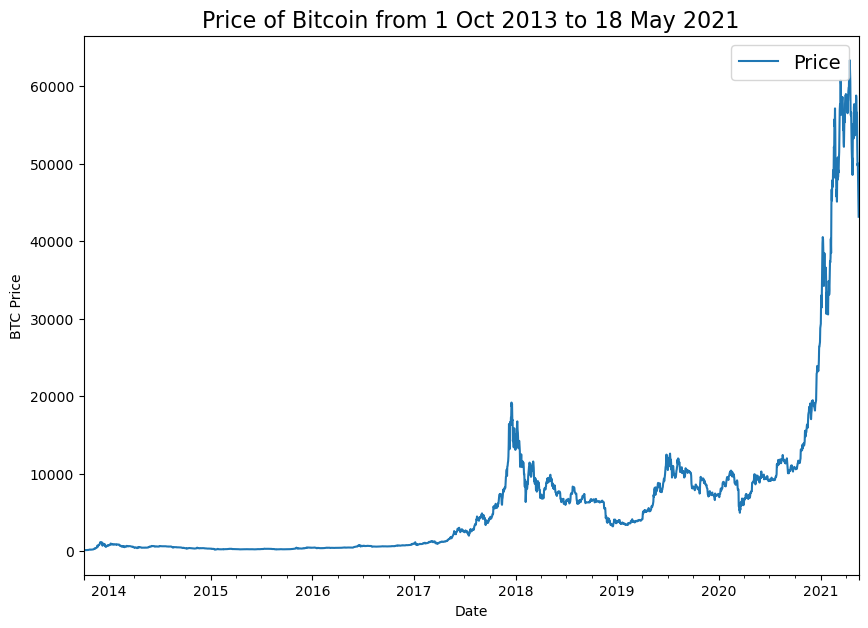

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14)

Video N°302: Reading in our Bitcoin data with Python's CSV module

In [8]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open(file="BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", mode='r') as f:
    csv_reader = csv.reader(f, delimiter=",")
    next(csv_reader) # skip first line (this gets rid of the column titles)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
        btc_price.append(float(line[2])) # get the closing price as float
# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

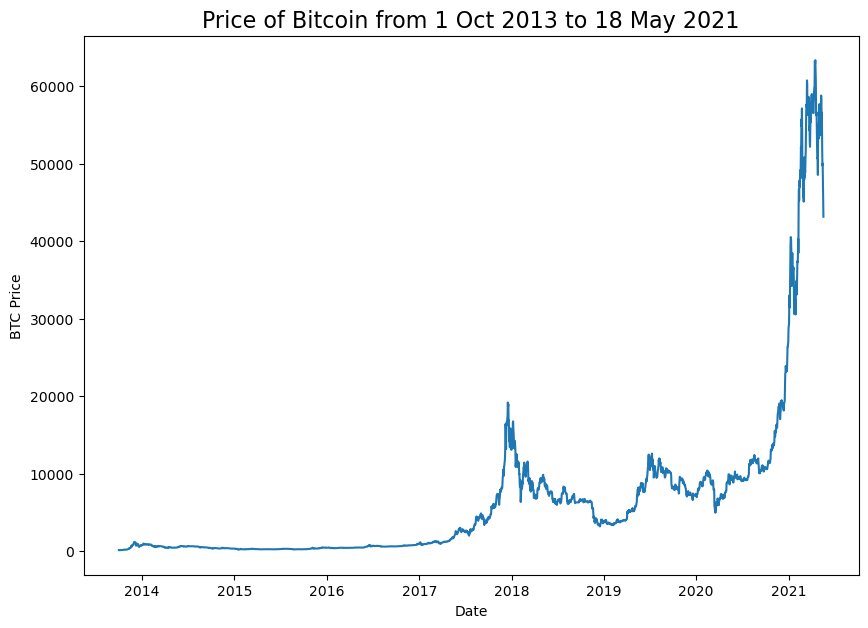

In [9]:
# Plot from CSV
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")

Video N°303: Creating train and test splits for time series (the wrong way)

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [10]:
bitcoin_prices[:5]

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [11]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [12]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

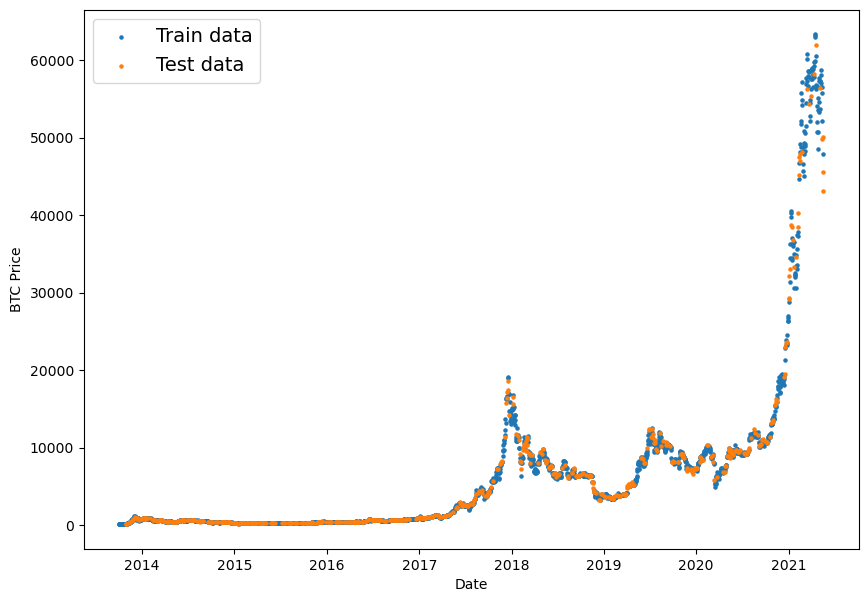

In [13]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show()

Video N°304: Creating train and test splits for time series (the right way)

### Create train & test sets for time series (the right way)

In [14]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you can change these values as needed, e.g. 90/10, 95/5

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

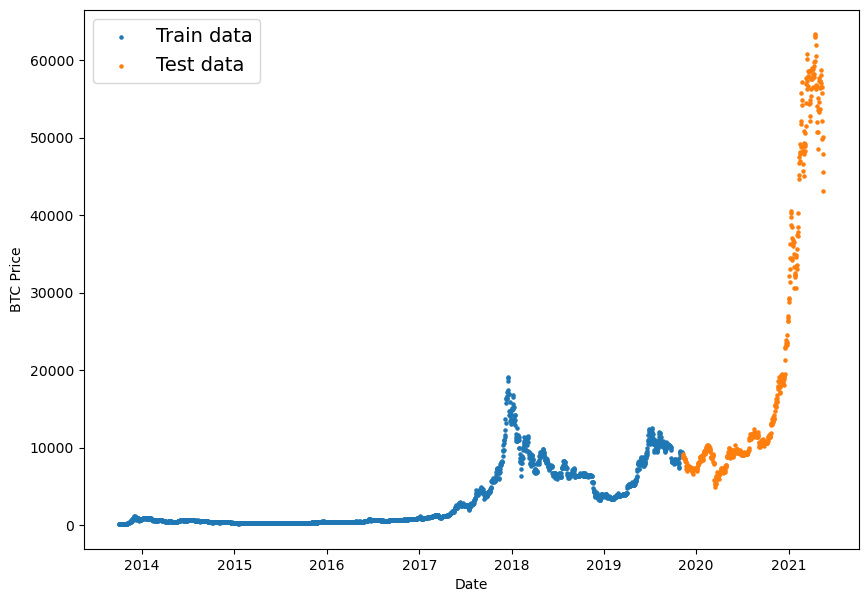

In [15]:
# Plot correctly made splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show()

Video N°305: Creating a plotting function to visualize our time series data

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [16]:
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps).
    
    Parameters
    ----------
    timesteps : array of timestep values
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (similar to start but for the end)
    label : label to show on plot about values, default None 
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)

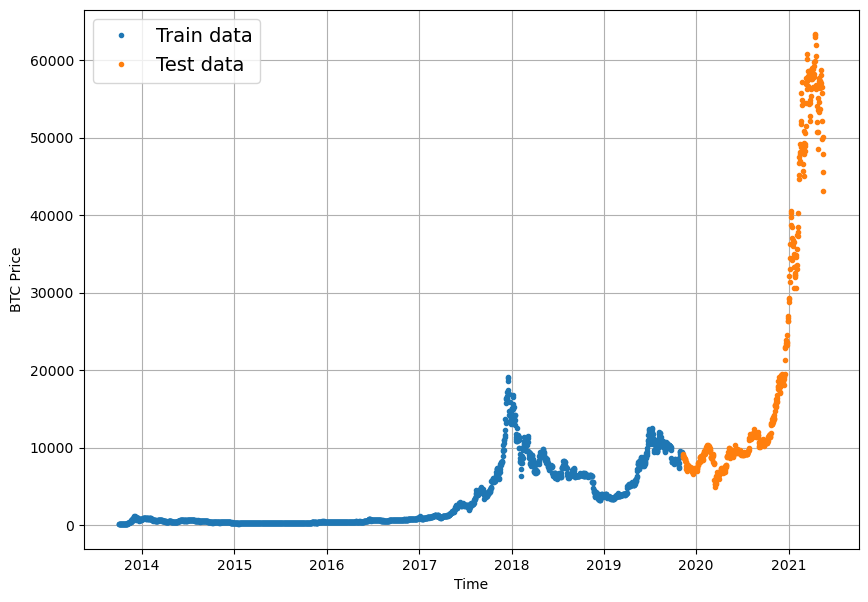

In [17]:
# Test out plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train,label="Train data")
plot_time_series(timesteps=X_test, values=y_test,label="Test data")

Video N°306: Discussing the various modelling experiments were going to be running

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

Modelling experiments we're running:
* 0	Naïve model (baseline)	
* 1	Dense model, horizon = 1, window = 7
* 2	Same as 1, 	horizon = 1, window = 30
* 3	Same as 1, 	horizon = 7, window =	30
* 4	Conv1D
* 5	LSTM
* 6	Same as 1 (but with multivariate data)
* 7	N-BEATs Algorithm
* 8	Ensemble (multiple models optimized on different loss functions)
* 9	Future prediction model (model to predict future values)
* 10	Same as 1 (but with turkey 🦃 data introduced)

Video N°307: Model 0:Making and visualizing a naive forecast model

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [18]:
y_test[:10]

array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
       8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
       8500.64355816, 8469.2608989 ])

In [19]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

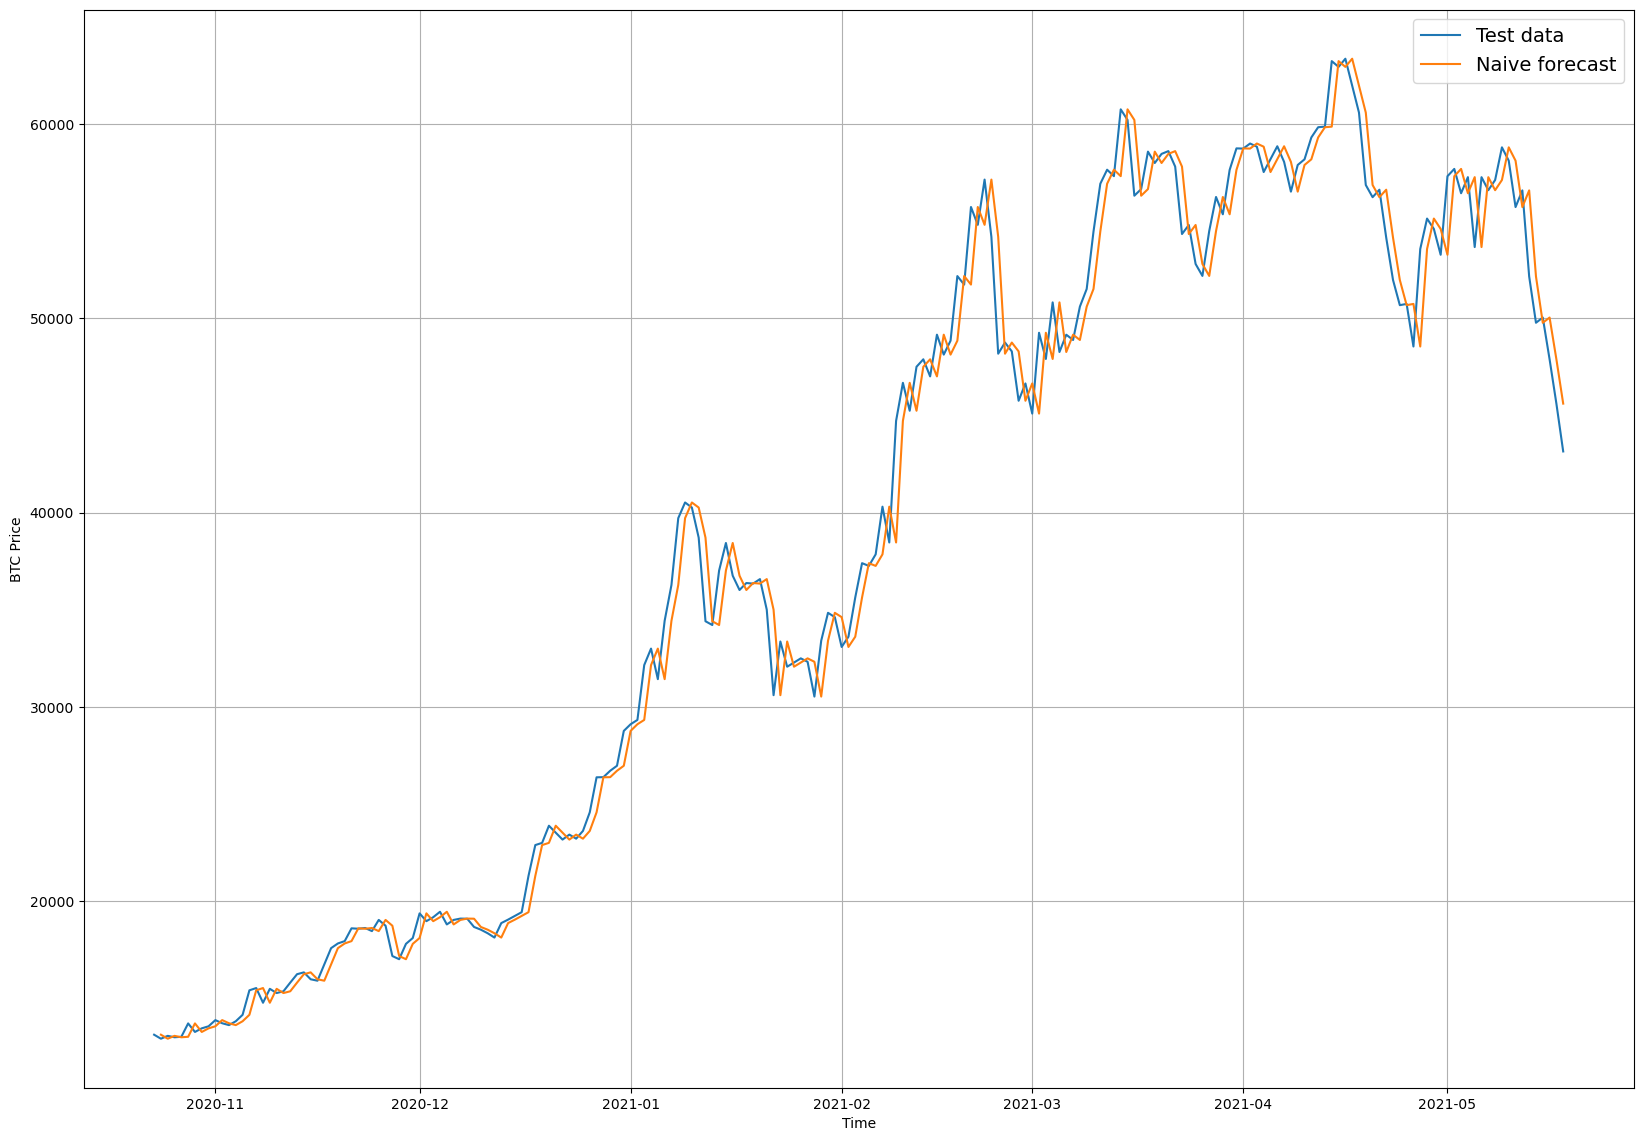

In [20]:
# Plot naive forecast
plt.figure(figsize=(20,14))
# plot_time_series(timesteps=X_train, values=y_train,label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive forecast")

> 🛠 **Exercise:** Spend 10 minutes reading the [simple forecasts chapter of Forecasting: Principles in Practice](https://otexts.com/fpp3/simple-methods.html). And have a search to find out why the naive forecast is hard to beat, does the term augoregressive come up? 

Video N°308: Discussing some of the most common time series evaluation metrics

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting. 

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

> 📖 **Resource:** For a deeper dive on the various kinds of time series forecasting methods see [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html) 

In [21]:
import tensorflow as tf

2024-05-14 15:01:49.702773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 15:01:49.702806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 15:01:49.703413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-14 15:01:49.709099: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data).
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    
    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)
    return mae / mae_naive_no_season

In [23]:
# Test MASE (this value should = 1 or be very close to 1 with the naive forecast)
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

2024-05-14 15:01:51.172068: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 15:01:51.193463: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 15:01:51.193687: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

0.9995699939182624

Video N°310: Creating a function to evaluate our model's forecasts with various metrics

In [24]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    # Calculate various evaluation metrics 
    mae = tf.keras.metrics.mean_absolute_error(y_true=y_true, y_pred=y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
    mase = mean_absolute_scaled_error(y_true=y_true, y_pred=y_pred)
    
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

That's one good looking evaluation function! 

Let's now see if it works...

In [25]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [26]:
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [27]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737222>

In [28]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

Video N°311: Discussing other non-TensorFlow kinds of time series forecasting models 

## Other models you can use for baselines and for actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with: [https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts](https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts)

Video N°312: Formatting data Part 2: Creating a function to label our windowed time series

## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [29]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [30]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [31]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
    """
    Creates labels for windowed dataset.
    
    E.g. if horizon=1
    Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [32]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


Video N°313: Discussing the use of windows and horizons in time series data
Video N°314: Writing a preprocessing function to turn time series data into windows & labels

We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing - https://numpy.org/doc/stable/reference/arrays.indexing.html.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon 

> 📖 **Resource:** The function we're about to create has been adapted from the following article: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [33]:
import numpy as np
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
    """
    # 1. Create a window of specific window_size (add the horzion on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    
    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")
    
    # 3. Index on the target array (a time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]
    # print(windowed_array)
    
    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(x=windowed_array,horizon=horizon)
    return windows, labels

In [34]:
full_windows, full_labels = make_windows(x=prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [35]:
# View the first 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [36]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> 🔑 **Note:** There's a function which does similar to the above in tf.keras.preprocessing, an extension could be to try and replicate what we've done using the premade function: [https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array) 

Video N°315: Turning our windowed time series data into training and test sets

## Turning windows into training and test sets

In [37]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [38]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of winodws and labels into train and test splits.
    """
    split_size = int(len(windows)* (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [39]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [40]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [41]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [42]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]),
               y_train[WINDOW_SIZE:])

True

Video N°316: Creating a modelling checkpoint to save our best performing model

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following: [https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)

In [43]:
# Create a function to implement a ModelCheckpoint callback with a specific filename
# already exists in my personal library
from MachineLearningUtils.training_utilities.model_callbacks import create_model_checkpoint

Video N°317: Model 1:Building, compiling and fitting a deep learning model on Bitcoin data

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizaiton and MAE loss function
* Batch size of 128 (previously we've used 32) 
* 100 epochs 

Why these values?

I picked them out of experimentation.

* **Hyperparameters** = values a machine learning practitioner (you!) can adjust themselves
* **Parameters** = values a model learns on its own

In [44]:
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # name our model so we can save it

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100


2024-05-14 15:01:52.725684: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1ef3fa91a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-14 15:01:52.725715: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-05-14 15:01:52.732022: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-14 15:01:52.745695: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1715691712.814976   39765 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/18 [>.............................] - ETA: 14s - loss: 3705.8152 - mae: 3705.8152 - mse: 28275444.0000INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 33ms/step - loss: 1989.7025 - mae: 1989.7025 - mse: 11198596.0000 - val_loss: 2975.5679 - val_mae: 2975.5679 - val_mse: 18961024.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 337.8730 - mae: 337.8730 - mse: 477304.4688INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 21ms/step - loss: 337.6450 - mae: 337.6450 - mse: 456355.2812 - val_loss: 1336.6846 - val_mae: 1336.6846 - val_mse: 5348008.5000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 167.3309 - mae: 167.3309 - mse: 115297.9453INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 27ms/step - loss: 241.4707 - mae: 241.4707 - mse: 282197.7500 - val_loss: 1218.8403 - val_mae: 1218.8403 - val_mse: 4905253.0000
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 294.9670 - mae: 294.9670 - mse: 430057.7500INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 218.1259 - mae: 218.1259 - mse: 244428.0000 - val_loss: 1187.1034 - val_mae: 1187.1034 - val_mse: 4672619.5000
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 224.2000 - mae: 224.2000 - mse: 184516.3438INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 210.3322 - mae: 210.3322 - mse: 229789.0000 - val_loss: 1171.2551 - val_mae: 1171.2551 - val_mse: 4478644.5000
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 164.0551 - mae: 164.0551 - mse: 99988.5781INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 21ms/step - loss: 209.2923 - mae: 209.2923 - mse: 226122.0625 - val_loss: 1162.2598 - val_mae: 1162.2598 - val_mse: 4498858.5000
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 261.9424 - mae: 261.9424 - mse: 453099.5625INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 205.0069 - mae: 205.0069 - mse: 218390.8281 - val_loss: 1097.0667 - val_mae: 1097.0667 - val_mse: 3994247.2500
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 184.6588 - mae: 184.6588 - mse: 131194.2344INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 191.2251 - mae: 191.2251 - mse: 192824.7656 - val_loss: 1059.5197 - val_mae: 1059.5197 - val_mse: 3628869.5000
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 155.7046 - mae: 155.7046 - mse: 108619.9688INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 19ms/step - loss: 184.2611 - mae: 184.2611 - mse: 180733.4531 - val_loss: 1054.3291 - val_mae: 1054.3291 - val_mse: 3486068.7500
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 202.4707 - mae: 202.4707 - mse: 273077.5938INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 179.1147 - mae: 179.1147 - mse: 171398.5312 - val_loss: 996.0761 - val_mae: 996.0761 - val_mse: 3216775.0000
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 198.1487 - mae: 198.1487 - mse: 164891.7812INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 173.2820 - mae: 173.2820 - mse: 160605.9062 - val_loss: 956.9171 - val_mae: 956.9171 - val_mse: 3047566.2500
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 168.9795 - mae: 168.9795 - mse: 152299.5625 - val_loss: 1051.6335 - val_mae: 1051.6335 - val_mse: 3181461.7500
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 137.7911 - mae: 137.7911 - mse: 117977.2422INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 22ms/step - loss: 166.5445 - mae: 166.5445 - mse: 150563.0312 - val_loss: 911.1793 - val_mae: 911.1793 - val_mse: 2691124.7500
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 185.9081 - mae: 185.9081 - mse: 164622.0625INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 158.3347 - mae: 158.3347 - mse: 136388.7344 - val_loss: 894.9881 - val_mae: 894.9881 - val_mse: 2558595.7500
Epoch 15/100
18/18 [==============================] - 0s 4ms/step - loss: 157.3822 - mae: 157.3822 - mse: 133909.4375 - val_loss: 993.8113 - val_mae: 993.8114 - val_mse: 2784387.2500
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 155.3158 - mae: 155.3158 - mse: 96796.4766INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 21ms/step - loss: 153.8629 - mae: 153.8629 - mse: 127922.6641 - val_loss: 839.2637 - val_mae: 839.2637 - val_mse: 2271928.7500
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 146.1224 - mae: 146.1224 - mse: 114153.3438INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 146.0977 - mae: 146.0977 - mse: 117682.9141 - val_loss: 830.5920 - val_mae: 830.5920 - val_mse: 2182266.5000
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 149.9148 - mae: 149.9148 - mse: 103452.7031INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 143.0887 - mae: 143.0887 - mse: 113392.6094 - val_loss: 811.2432 - val_mae: 811.2432 - val_mse: 2079034.5000
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 83.6899 - mae: 83.6899 - mse: 37912.5508INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 139.1011 - mae: 139.1011 - mse: 107993.0391 - val_loss: 777.2015 - val_mae: 777.2015 - val_mse: 1953638.6250
Epoch 20/100
18/18 [==============================] - 0s 3ms/step - loss: 139.3462 - mae: 139.3462 - mse: 109187.9062 - val_loss: 790.8034 - val_mae: 790.8034 - val_mse: 2067012.6250
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 184.4887 - mae: 184.4887 - mse: 150507.2500INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 19ms/step - loss: 139.9445 - mae: 139.9445 - mse: 106984.4062 - val_loss: 765.8038 - val_mae: 765.8038 - val_mse: 1949188.8750
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 186.6983 - mae: 186.6983 - mse: 212174.2969INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 136.9607 - mae: 136.9607 - mse: 103271.1719 - val_loss: 720.7443 - val_mae: 720.7443 - val_mse: 1733344.5000
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 147.1476 - mae: 147.1476 - mse: 99766.7422INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 19ms/step - loss: 130.2525 - mae: 130.2525 - mse: 94763.8672 - val_loss: 709.4492 - val_mae: 709.4492 - val_mse: 1673572.3750
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 143.9228 - mae: 143.9228 - mse: 96303.8125INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 19ms/step - loss: 132.8943 - mae: 132.8943 - mse: 96738.8125 - val_loss: 703.4730 - val_mae: 703.4730 - val_mse: 1631848.0000
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 136.6232 - mae: 136.6232 - mse: 76255.7109INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 34ms/step - loss: 131.7320 - mae: 131.7320 - mse: 93966.8516 - val_loss: 687.6672 - val_mae: 687.6672 - val_mse: 1596810.8750
Epoch 26/100
18/18 [==============================] - 0s 4ms/step - loss: 127.5155 - mae: 127.5155 - mse: 90400.5000 - val_loss: 713.6547 - val_mae: 713.6547 - val_mse: 1700641.8750
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 190.3789 - mae: 190.3789 - mse: 169175.0781INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 19ms/step - loss: 127.4826 - mae: 127.4826 - mse: 91276.7188 - val_loss: 682.8084 - val_mae: 682.8084 - val_mse: 1577969.1250
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 129.6939 - mae: 129.6939 - mse: 86815.7812INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 19ms/step - loss: 122.6256 - mae: 122.6256 - mse: 85460.3125 - val_loss: 665.6946 - val_mae: 665.6946 - val_mse: 1484619.0000
Epoch 29/100
18/18 [==============================] - 0s 3ms/step - loss: 121.7020 - mae: 121.7020 - mse: 85263.4844 - val_loss: 689.6613 - val_mae: 689.6613 - val_mse: 1527828.7500
Epoch 30/100
18/18 [==============================] - 0s 3ms/step - loss: 124.9166 - mae: 124.9166 - mse: 85815.9609 - val_loss: 683.1807 - val_mae: 683.1807 - val_mse: 1504517.5000
Epoch 31/100
18/18 [==============================] - 0s 3ms/step - loss: 131.2120 - mae: 131.2120 - mse: 89847.7344 - val_loss: 840.1994 - val_mae: 840.1994 - val_mse: 1960860.5000
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 141.7597 - mae: 141.7597 - mse: 97974.8828INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArg

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 130.0746 - mae: 130.0746 - mse: 87950.3672 - val_loss: 661.1116 - val_mae: 661.1116 - val_mse: 1443451.8750
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 151.4247 - mae: 151.4247 - mse: 147716.4219INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 19ms/step - loss: 122.8317 - mae: 122.8317 - mse: 80233.8672 - val_loss: 634.7261 - val_mae: 634.7261 - val_mse: 1387036.8750
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 131.7054 - mae: 131.7054 - mse: 129944.7344INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 118.7893 - mae: 118.7893 - mse: 81259.4375 - val_loss: 633.6588 - val_mae: 633.6588 - val_mse: 1373623.5000
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 101.2740 - mae: 101.2740 - mse: 50197.2656INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 118.2999 - mae: 118.2999 - mse: 81393.0938 - val_loss: 631.1353 - val_mae: 631.1353 - val_mse: 1362434.0000
Epoch 36/100
18/18 [==============================] - 0s 4ms/step - loss: 125.8159 - mae: 125.8159 - mse: 83954.4375 - val_loss: 744.7947 - val_mae: 744.7947 - val_mse: 1644720.6250
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 157.1852 - mae: 157.1852 - mse: 122041.6328INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 18ms/step - loss: 120.0792 - mae: 120.0792 - mse: 79701.7812 - val_loss: 621.8463 - val_mae: 621.8463 - val_mse: 1335803.8750
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 104.6575 - mae: 104.6575 - mse: 64865.6875INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 115.6570 - mae: 115.6570 - mse: 78234.0703 - val_loss: 621.1701 - val_mae: 621.1701 - val_mse: 1329202.5000
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 130.2270 - mae: 130.2270 - mse: 91324.6641INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 19ms/step - loss: 115.6156 - mae: 115.6156 - mse: 78464.4688 - val_loss: 613.6122 - val_mae: 613.6122 - val_mse: 1315247.6250
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 103.9900 - mae: 103.9900 - mse: 86653.2031INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 19ms/step - loss: 114.9600 - mae: 114.9600 - mse: 77803.4531 - val_loss: 612.1293 - val_mae: 612.1293 - val_mse: 1303908.0000
Epoch 41/100
18/18 [==============================] - 0s 3ms/step - loss: 117.3787 - mae: 117.3787 - mse: 78817.7188 - val_loss: 657.8817 - val_mae: 657.8817 - val_mse: 1439625.5000
Epoch 42/100
18/18 [==============================] - 0s 3ms/step - loss: 122.7297 - mae: 122.7297 - mse: 82377.2578 - val_loss: 618.8231 - val_mae: 618.8231 - val_mse: 1327718.5000
Epoch 43/100
18/18 [==============================] - 0s 3ms/step - loss: 114.0549 - mae: 114.0549 - mse: 75605.1250 - val_loss: 612.2468 - val_mae: 612.2468 - val_mse: 1307371.2500
Epoch 44/100
18/18 [==============================] - 0s 4ms/step - loss: 114.2479 - mae: 114.2479 - mse: 75878.1797 - val_loss: 615.3672 - val_mae: 615.3672 - val_mse: 1314392.0000
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 81.4443 - mae: 81.4443 - mse: 38

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 19ms/step - loss: 115.3283 - mae: 115.3283 - mse: 77918.6953 - val_loss: 608.7693 - val_mae: 608.7693 - val_mse: 1284553.8750
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 87.2755 - mae: 87.2755 - mse: 54390.6367INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 19ms/step - loss: 114.6987 - mae: 114.6987 - mse: 76419.0469 - val_loss: 607.7979 - val_mae: 607.7979 - val_mse: 1279924.7500
Epoch 47/100
18/18 [==============================] - 0s 4ms/step - loss: 113.7391 - mae: 113.7391 - mse: 76932.7031 - val_loss: 690.8447 - val_mae: 690.8447 - val_mse: 1473403.3750
Epoch 48/100
18/18 [==============================] - 0s 3ms/step - loss: 115.0614 - mae: 115.0614 - mse: 75395.0547 - val_loss: 675.9482 - val_mae: 675.9482 - val_mse: 1434427.2500
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 177.7187 - mae: 177.7187 - mse: 122995.7500INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 18ms/step - loss: 119.0088 - mae: 119.0088 - mse: 77482.2344 - val_loss: 600.3089 - val_mae: 600.3089 - val_mse: 1259130.8750
Epoch 50/100
 1/18 [>.............................] - ETA: 0s - loss: 133.3584 - mae: 133.3584 - mse: 144448.3906INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 18ms/step - loss: 111.9065 - mae: 111.9065 - mse: 74832.7188 - val_loss: 594.5295 - val_mae: 594.5295 - val_mse: 1246992.3750
Epoch 51/100
18/18 [==============================] - 0s 4ms/step - loss: 112.3042 - mae: 112.3042 - mse: 74198.9297 - val_loss: 604.0760 - val_mae: 604.0760 - val_mse: 1265634.7500
Epoch 52/100
18/18 [==============================] - 0s 3ms/step - loss: 114.0277 - mae: 114.0277 - mse: 76582.8750 - val_loss: 600.6510 - val_mae: 600.6510 - val_mse: 1264035.3750
Epoch 53/100
 1/18 [>.............................] - ETA: 0s - loss: 61.3360 - mae: 61.3360 - mse: 22199.7246INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 116.0373 - mae: 116.0373 - mse: 76519.4062 - val_loss: 589.8604 - val_mae: 589.8604 - val_mse: 1230850.5000
Epoch 54/100
18/18 [==============================] - 0s 4ms/step - loss: 116.2958 - mae: 116.2958 - mse: 77079.3359 - val_loss: 685.8250 - val_mae: 685.8250 - val_mse: 1449237.7500
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 142.4588 - mae: 142.4588 - mse: 101847.3594INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 114.7928 - mae: 114.7928 - mse: 74506.6719 - val_loss: 588.4565 - val_mae: 588.4565 - val_mse: 1227504.1250
Epoch 56/100
18/18 [==============================] - 0s 4ms/step - loss: 111.5352 - mae: 111.5352 - mse: 73506.5938 - val_loss: 773.5766 - val_mae: 773.5766 - val_mse: 1763287.8750
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 125.4734 - mae: 125.4734 - mse: 84562.3125 - val_loss: 636.2244 - val_mae: 636.2244 - val_mse: 1345104.6250
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 114.0909 - mae: 114.0909 - mse: 74504.5312 - val_loss: 588.7001 - val_mae: 588.7001 - val_mse: 1227395.6250
Epoch 59/100
18/18 [==============================] - 0s 3ms/step - loss: 110.8094 - mae: 110.8094 - mse: 72988.2344 - val_loss: 589.4822 - val_mae: 589.4822 - val_mse: 1229103.2500
Epoch 60/100
 1/18 [>.............................] - ETA: 0s - loss: 93.7005 - mae: 93.7005 - mse: 39

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 110.5685 - mae: 110.5685 - mse: 72153.6953 - val_loss: 585.9180 - val_mae: 585.9180 - val_mse: 1215137.0000
Epoch 61/100
18/18 [==============================] - 0s 3ms/step - loss: 110.1608 - mae: 110.1608 - mse: 72756.0938 - val_loss: 587.3831 - val_mae: 587.3831 - val_mse: 1217651.2500
Epoch 62/100
 1/18 [>.............................] - ETA: 0s - loss: 72.4360 - mae: 72.4360 - mse: 35316.0352INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 19ms/step - loss: 109.6787 - mae: 109.6787 - mse: 71266.3281 - val_loss: 585.2829 - val_mae: 585.2829 - val_mse: 1215349.5000
Epoch 63/100
18/18 [==============================] - 0s 3ms/step - loss: 111.3241 - mae: 111.3241 - mse: 73094.7812 - val_loss: 612.7057 - val_mae: 612.7057 - val_mse: 1270000.6250
Epoch 64/100
18/18 [==============================] - 0s 4ms/step - loss: 113.9785 - mae: 113.9785 - mse: 74346.3672 - val_loss: 692.8860 - val_mae: 692.8860 - val_mse: 1457556.2500
Epoch 65/100
18/18 [==============================] - 0s 3ms/step - loss: 119.8479 - mae: 119.8479 - mse: 79255.1719 - val_loss: 616.9117 - val_mae: 616.9117 - val_mse: 1278432.7500
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 129.8598 - mae: 129.8598 - mse: 94649.6406INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArg

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 19ms/step - loss: 112.1320 - mae: 112.1320 - mse: 72140.1172 - val_loss: 583.4981 - val_mae: 583.4981 - val_mse: 1208424.2500
Epoch 67/100
18/18 [==============================] - 0s 3ms/step - loss: 108.7434 - mae: 108.7434 - mse: 70369.9141 - val_loss: 614.7626 - val_mae: 614.7626 - val_mse: 1279378.6250
Epoch 68/100
18/18 [==============================] - 0s 3ms/step - loss: 115.6386 - mae: 115.6386 - mse: 71960.5078 - val_loss: 693.2101 - val_mae: 693.2100 - val_mse: 1488266.1250
Epoch 69/100
18/18 [==============================] - 0s 3ms/step - loss: 122.3032 - mae: 122.3032 - mse: 79914.3516 - val_loss: 651.4642 - val_mae: 651.4642 - val_mse: 1368917.0000
Epoch 70/100
18/18 [==============================] - 0s 3ms/step - loss: 121.5937 - mae: 121.5937 - mse: 79254.3438 - val_loss: 588.6024 - val_mae: 588.6024 - val_mse: 1219029.6250
Epoch 71/100
18/18 [==============================] - 0s 3ms/step - loss: 110.4218 - mae: 110.4218 - m

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 31ms/step - loss: 109.2317 - mae: 109.2317 - mse: 70987.2031 - val_loss: 577.4902 - val_mae: 577.4902 - val_mse: 1191859.3750
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 110.7274 - mae: 110.7274 - mse: 71685.7734 - val_loss: 614.1544 - val_mae: 614.1544 - val_mse: 1273042.3750
Epoch 74/100
 1/18 [>.............................] - ETA: 0s - loss: 166.5267 - mae: 166.5267 - mse: 169463.5312INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 108.1406 - mae: 108.1406 - mse: 70653.8828 - val_loss: 574.8873 - val_mae: 574.8873 - val_mse: 1184388.8750
Epoch 75/100
18/18 [==============================] - 0s 3ms/step - loss: 109.3855 - mae: 109.3855 - mse: 70221.6094 - val_loss: 643.3391 - val_mae: 643.3391 - val_mse: 1327152.6250
Epoch 76/100
 1/18 [>.............................] - ETA: 0s - loss: 87.9286 - mae: 87.9286 - mse: 30287.3145INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 19ms/step - loss: 113.7752 - mae: 113.7752 - mse: 73354.7266 - val_loss: 572.2126 - val_mae: 572.2126 - val_mse: 1177018.3750
Epoch 77/100
18/18 [==============================] - 0s 4ms/step - loss: 110.9873 - mae: 110.9873 - mse: 70844.3438 - val_loss: 578.5753 - val_mae: 578.5753 - val_mse: 1191564.1250
Epoch 78/100
18/18 [==============================] - 0s 4ms/step - loss: 108.3178 - mae: 108.3178 - mse: 69363.7578 - val_loss: 578.6289 - val_mae: 578.6289 - val_mse: 1191210.8750
Epoch 79/100
18/18 [==============================] - 0s 4ms/step - loss: 109.1784 - mae: 109.1784 - mse: 72462.6719 - val_loss: 598.6230 - val_mae: 598.6230 - val_mse: 1233324.8750
Epoch 80/100
 1/18 [>.............................] - ETA: 0s - loss: 117.1546 - mae: 117.1546 - mse: 127246.9609INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownAr

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 109.0160 - mae: 109.0160 - mse: 70728.1953 - val_loss: 571.6365 - val_mae: 571.6365 - val_mse: 1175032.1250
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 96.8765 - mae: 96.8765 - mse: 45704.7188INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 107.1332 - mae: 107.1332 - mse: 69590.5312 - val_loss: 570.8294 - val_mae: 570.8294 - val_mse: 1172659.7500
Epoch 82/100
 1/18 [>.............................] - ETA: 0s - loss: 188.7505 - mae: 188.7505 - mse: 225111.3438INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 20ms/step - loss: 113.3108 - mae: 113.3108 - mse: 74307.1797 - val_loss: 568.9525 - val_mae: 568.9525 - val_mse: 1169201.1250
Epoch 83/100
18/18 [==============================] - 0s 3ms/step - loss: 112.1007 - mae: 112.1007 - mse: 73063.8281 - val_loss: 635.2050 - val_mae: 635.2050 - val_mse: 1314925.1250
Epoch 84/100
18/18 [==============================] - 0s 4ms/step - loss: 113.6595 - mae: 113.6595 - mse: 71762.5000 - val_loss: 593.1516 - val_mae: 593.1516 - val_mse: 1221361.5000
Epoch 85/100
18/18 [==============================] - 0s 4ms/step - loss: 109.2611 - mae: 109.2611 - mse: 71501.9141 - val_loss: 569.9318 - val_mae: 569.9318 - val_mse: 1170074.7500
Epoch 86/100
18/18 [==============================] - 0s 3ms/step - loss: 108.7848 - mae: 108.7848 - mse: 69827.1562 - val_loss: 641.0225 - val_mae: 641.0225 - val_mse: 1317143.0000
Epoch 87/100
 1/18 [>.............................] - ETA: 0s - loss: 129.8069 - mae: 129.8069 - mse: 

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 21ms/step - loss: 109.4210 - mae: 109.4210 - mse: 69157.8828 - val_loss: 568.1354 - val_mae: 568.1354 - val_mse: 1166116.3750
Epoch 88/100
18/18 [==============================] - 0s 4ms/step - loss: 108.3921 - mae: 108.3921 - mse: 70596.4844 - val_loss: 605.9670 - val_mae: 605.9670 - val_mse: 1248394.8750
Epoch 89/100
18/18 [==============================] - 0s 3ms/step - loss: 111.2674 - mae: 111.2674 - mse: 69478.9766 - val_loss: 589.4197 - val_mae: 589.4197 - val_mse: 1209582.2500
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 107.6898 - mae: 107.6898 - mse: 68519.7109 - val_loss: 606.3115 - val_mae: 606.3115 - val_mse: 1238930.5000
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 109.9590 - mae: 109.9590 - mse: 70702.9297 - val_loss: 597.5914 - val_mae: 597.5914 - val_mse: 1229967.1250
Epoch 92/100
18/18 [==============================] - 0s 3ms/step - loss: 108.7303 - mae: 108.7303 - m

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 19ms/step - loss: 106.9427 - mae: 106.9427 - mse: 68485.0859 - val_loss: 567.0930 - val_mae: 567.0930 - val_mse: 1162599.2500
Epoch 96/100
18/18 [==============================] - 0s 4ms/step - loss: 115.2075 - mae: 115.2075 - mse: 72911.5000 - val_loss: 595.8095 - val_mae: 595.8095 - val_mse: 1223156.6250
Epoch 97/100
18/18 [==============================] - 0s 4ms/step - loss: 109.5840 - mae: 109.5840 - mse: 70457.0703 - val_loss: 623.8096 - val_mae: 623.8096 - val_mse: 1287838.6250
Epoch 98/100
 1/18 [>.............................] - ETA: 0s - loss: 122.6215 - mae: 122.6215 - mse: 68601.2812INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307310>, 139774886919696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc307c40>, 139774817438832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc305a80>, 139774814666016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fdc1e02b0>, 139774817128240), {}).


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 19ms/step - loss: 109.6049 - mae: 109.6049 - mse: 69649.0547 - val_loss: 566.9188 - val_mae: 566.9188 - val_mse: 1163265.2500
Epoch 99/100
18/18 [==============================] - 0s 3ms/step - loss: 108.7056 - mae: 108.7056 - mse: 69966.6094 - val_loss: 573.6953 - val_mae: 573.6953 - val_mse: 1172486.5000
Epoch 100/100
18/18 [==============================] - 0s 3ms/step - loss: 108.3135 - mae: 108.3135 - mse: 68585.1562 - val_loss: 608.9414 - val_mae: 608.9414 - val_mse: 1238908.5000


In [45]:
# Evaluate model on test data
model_1.evaluate(x=test_windows, y=test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 608.9414 - mae: 608.9414 - mse: 1238908.6250


[608.94140625, 608.94140625, 1238908.625]

In [46]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model(filepath="model_experiments/model_1_dense/")
model_1.evaluate(x=test_windows, y=test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 566.9189 - mae: 566.9189 - mse: 1163265.5000


[566.9189453125, 566.9189453125, 1163265.5]

Video N°318: Creating a function to make predictions with our trained models

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only psuedo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions 

In [47]:
def make_preds(model, input_data):
    """
    Uses model to m
    ake predictions input_data.
    """
    forecast = model.predict(x=input_data)
    return tf.squeeze(forecast) # return 1D array of predictions    

In [48]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model=model_1, input_data=test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8851.355, 8786.658, 8999.178, 8803.928, 8774.101, 8681.442,
        8676.357, 8546.825, 8439.277, 8514.952], dtype=float32)>)

In [49]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 566.91895,
 'mse': 1163265.5,
 'rmse': 1078.5479,
 'mape': 2.5354218,
 'mase': 0.9959196}

In [50]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

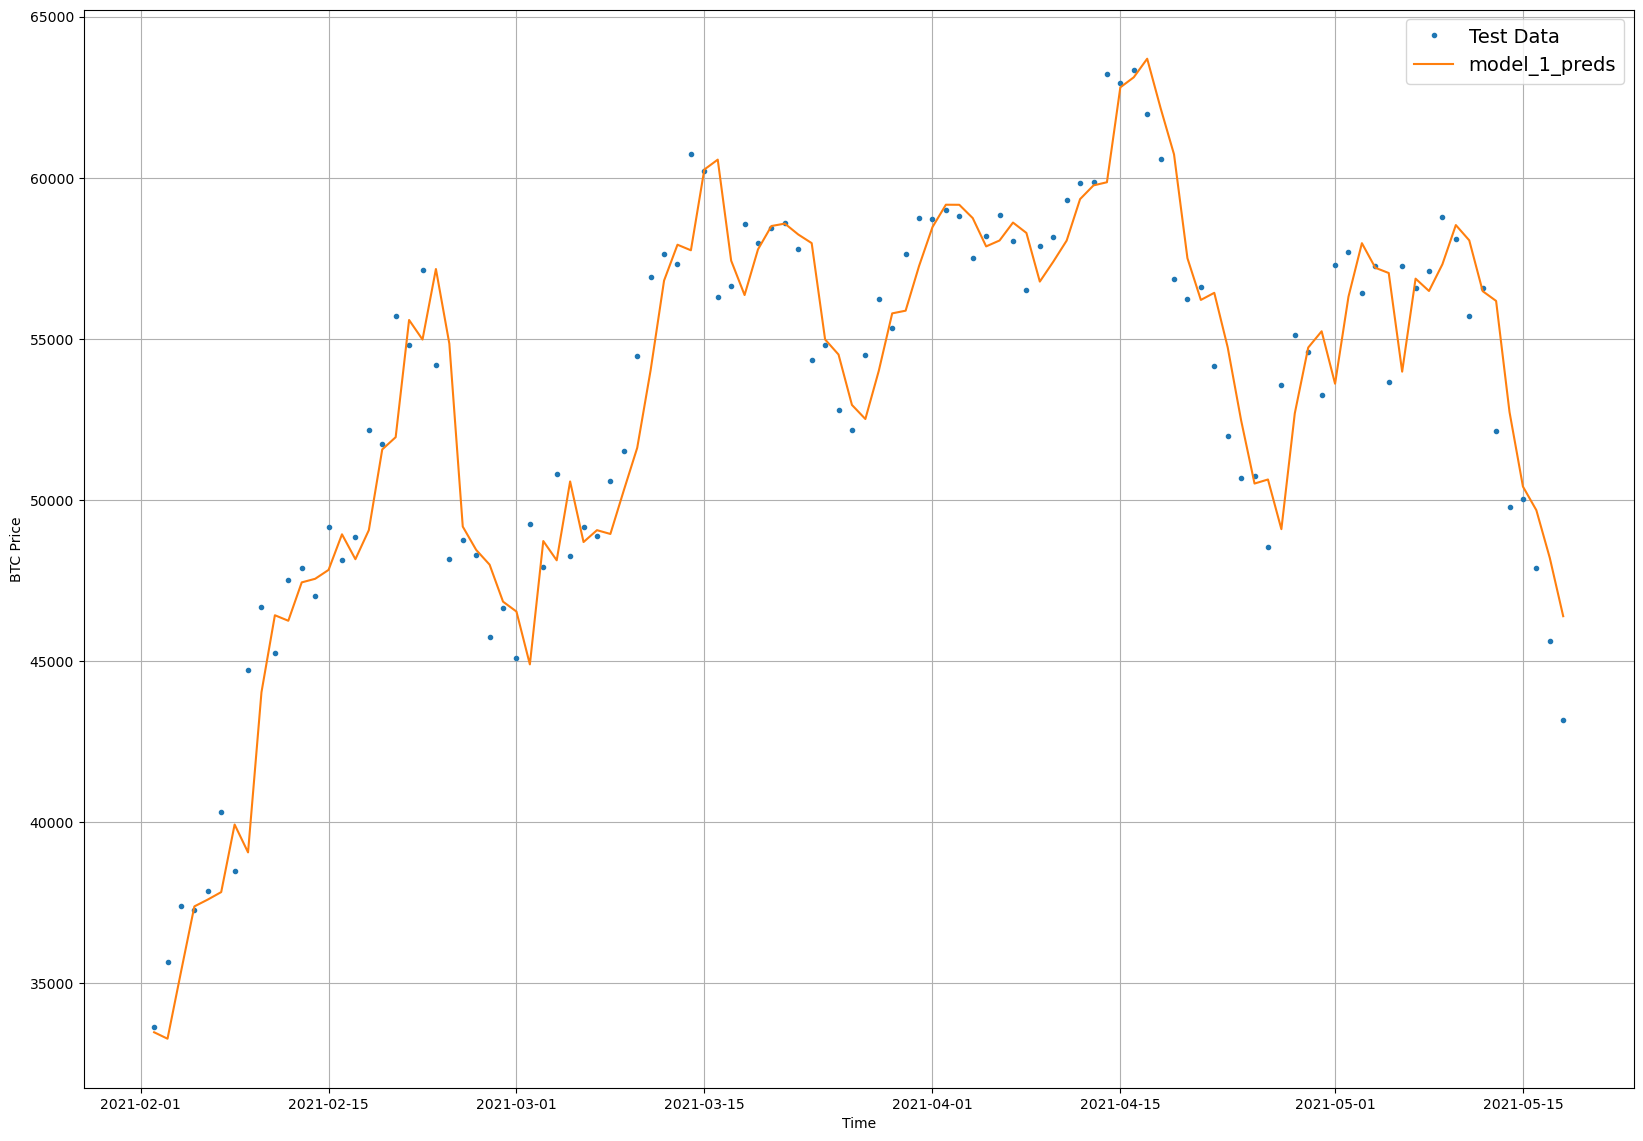

In [51]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize=(20,14))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="model_1_preds")

Video N°319: Model 2: Building, fitting and evaluating a deep model with a larger window size

## Model 2: Dense (window = 30, horizon = 1)

In [52]:
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)
WINDOW_SIZE = 30 # use 30 timesteps in past

In [53]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(x=prices,
                                         window_size=WINDOW_SIZE,
                                         horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [54]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [55]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=HORIZON, activation="linear")
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c670610>, 139774611999520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c672860>, 139774611840640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5fe8c0>, 139774612007120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c5febc0>, 139774612055392), {}).


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


In [56]:
# Evaluate model 2 on test data
model_2.evaluate(x=test_windows, y=test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 740.2534


740.2533569335938

In [57]:
# Load in the best performing model
model_2 = tf.keras.models.load_model(filepath="model_experiments/model_2_dense/")
model_2.evaluate(x=test_windows, y=test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 615.9223


615.9223022460938

In [58]:
# Get forecast predictions
model_2_preds = make_preds(model=model_2, input_data=test_windows)

18/18 [==============================] - 0s 802us/step


In [59]:
tf.squeeze(test_labels).shape, model_2_preds.shape

(TensorShape([552]), TensorShape([552]))

In [60]:
# Evaluate results for model_2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 615.9223,
 'mse': 1319967.5,
 'rmse': 1148.8983,
 'mape': 2.7622569,
 'mase': 1.0766382}

In [61]:
model_1_results

{'mae': 566.91895,
 'mse': 1163265.5,
 'rmse': 1078.5479,
 'mape': 2.5354218,
 'mase': 0.9959196}

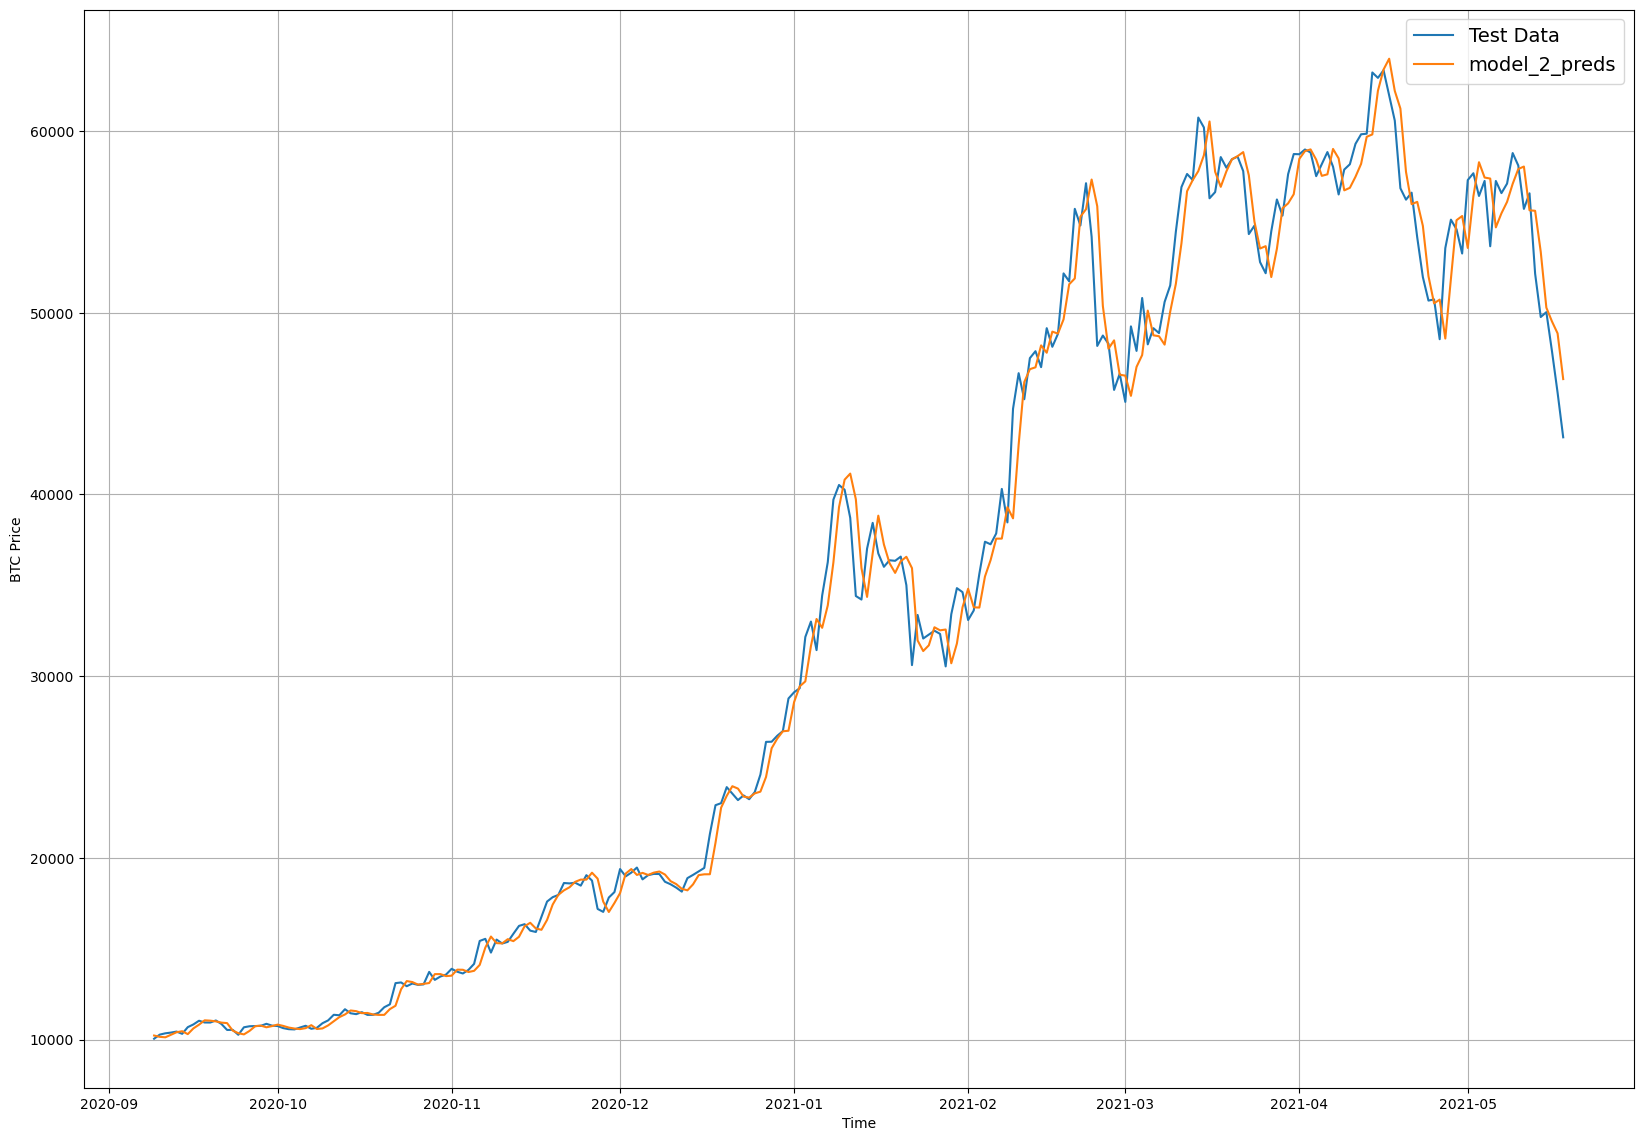

In [62]:
offset=300
plt.figure(figsize=(20, 14))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 format="-",
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_2_preds,
                 start=offset,
                 format='-',
                 label="model_2_preds")

Video N°320: Model 3: Building, fitting and evaluating a model with larger horizon size

## Model 3: Dense (window = 30, horizon = 7)

In [63]:
prices[:10]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  , 123.033  , 124.049  , 125.96116])

In [64]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [65]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [66]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input and output sizes)
model_3 = tf.keras.Sequential([
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=HORIZON)
], name="model_3_dense")

# Compile
model_3.compile(loss="MAE",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(x=train_windows,
            y=train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(30, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44a4d0>, 139774615944000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd02b11b0>, 139772400142496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c44b8b0>, 139772401789856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c48c820>, 139772401787536), {}).


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


In [67]:
# Evaluate the model on the test data
model_3.evaluate(x=test_windows, y=test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1362.9222


1362.9222412109375

In [68]:
# Load best version of model_3 and evaluate
model_3 = tf.keras.models.load_model(filepath="model_experiments/model_3_dense")
model_3.evaluate(x=test_windows, y=test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1247.3047


1247.3046875

In [69]:
# Make predictions with model_3
model_3_preds = make_preds(model=model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9333.89 , 9392.015, 9592.79 , 9470.877, 9712.658, 9298.959,
        9449.45 ],
       [8874.28 , 8990.059, 9307.371, 9127.671, 9374.842, 8973.637,
        9182.17 ],
       [8903.788, 8871.474, 9131.007, 8910.637, 9103.906, 8921.505,
        9137.455],
       [9077.384, 8955.464, 9207.201, 9169.082, 9205.059, 9292.247,
        9099.372],
       [8822.775, 8850.508, 9097.496, 8945.438, 9160.484, 8942.801,
        8924.706]], dtype=float32)>

In [70]:
model_2_results

{'mae': 615.9223,
 'mse': 1319967.5,
 'rmse': 1148.8983,
 'mape': 2.7622569,
 'mase': 1.0766382}

In [71]:
model_3_preds.shape, model_2_preds.shape, model_1_preds.shape

(TensorShape([551, 7]), TensorShape([552]), TensorShape([556]))

In [72]:
# Evaluate model_3 results (these are going multi-dimensional because we're trying to predict more than one timestep at a time)
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  671.162   ,   393.35645 ,   343.5085  ,   517.09235 ,
          409.11063 ,   440.18158 ,   411.3055  ,   425.53467 ,
          488.90298 ,   580.6007  ,   918.6357  ,   904.0179  ,
          845.3161  ,   858.7842  ,   555.20575 ,   219.16504 ,
          227.9241  ,   224.45891 ,   257.02805 ,   255.04875 ,
          191.49666 ,   169.77232 ,   247.29102 ,   304.6462  ,
          186.88832 ,   176.7452  ,   106.45319 ,   154.48563 ,
          156.41762 ,   195.79834 ,   309.0231  ,   385.00293 ,
          324.75543 ,   384.84662 ,   269.4294  ,   323.95312 ,
          303.0445  ,   238.57156 ,   231.68416 ,   227.8584  ,
          473.2844  ,    92.68206 ,   114.922714,    82.80155 ,
          118.642715,    95.70675 ,   116.94796 ,    91.85205 ,
           84.9707  ,   114.70466 ,   112.32708 ,   172.07645 ,
          187.22887 ,   150.75768 ,   277.3024  ,   353.45102 ,
          563.46857 ,   512.62164 ,   513.7308  ,   585.28723 ,
          418.336   ,   262.9311 

Video N°321: Adjusting the evaluation function to work with larger horizons

## Make our evaluation function work for larger horizons

In [73]:
tf.reduce_mean(input_tensor=model_3_results["mae"]).numpy()

1247.3047

In [74]:
model_2_results["mae"].ndim

0

In [75]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [76]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1247.3047,
 'mse': 5472930.0,
 'rmse': 1435.3646,
 'mape': 5.5806117,
 'mase': 2.2195091}

Video N°322: Model 3: Visualizing the results

We've made and evaluated predictions with `model_3`, let's visualize, visualize, visualize!

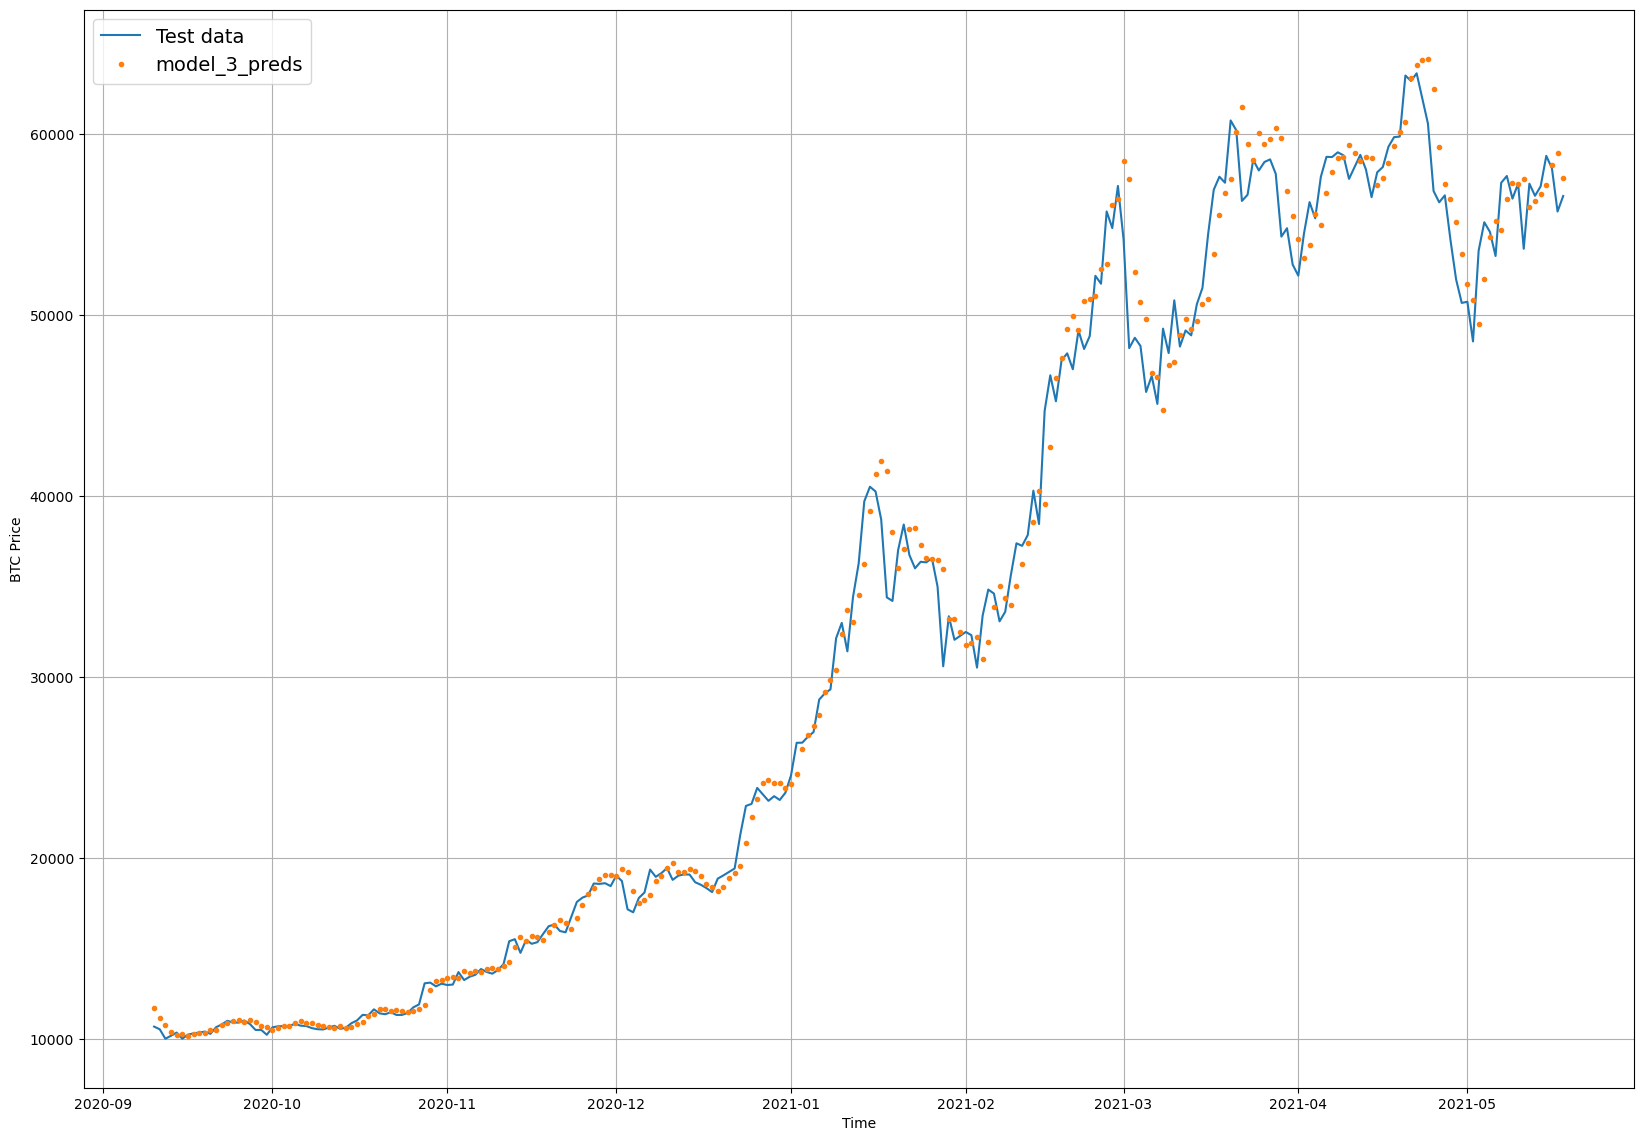

In [77]:
offset = 300
plt.figure(figsize=(20, 14))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 format='-',
                 label='Test data')
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 label="model_3_preds")

Video N°323: Comparing our modelling experiments so far and discussing autocorrelation

## Which of our models is performing the best so far? 

So we've trained a few models, now let's compare them and see how they've gone... 

<Axes: >

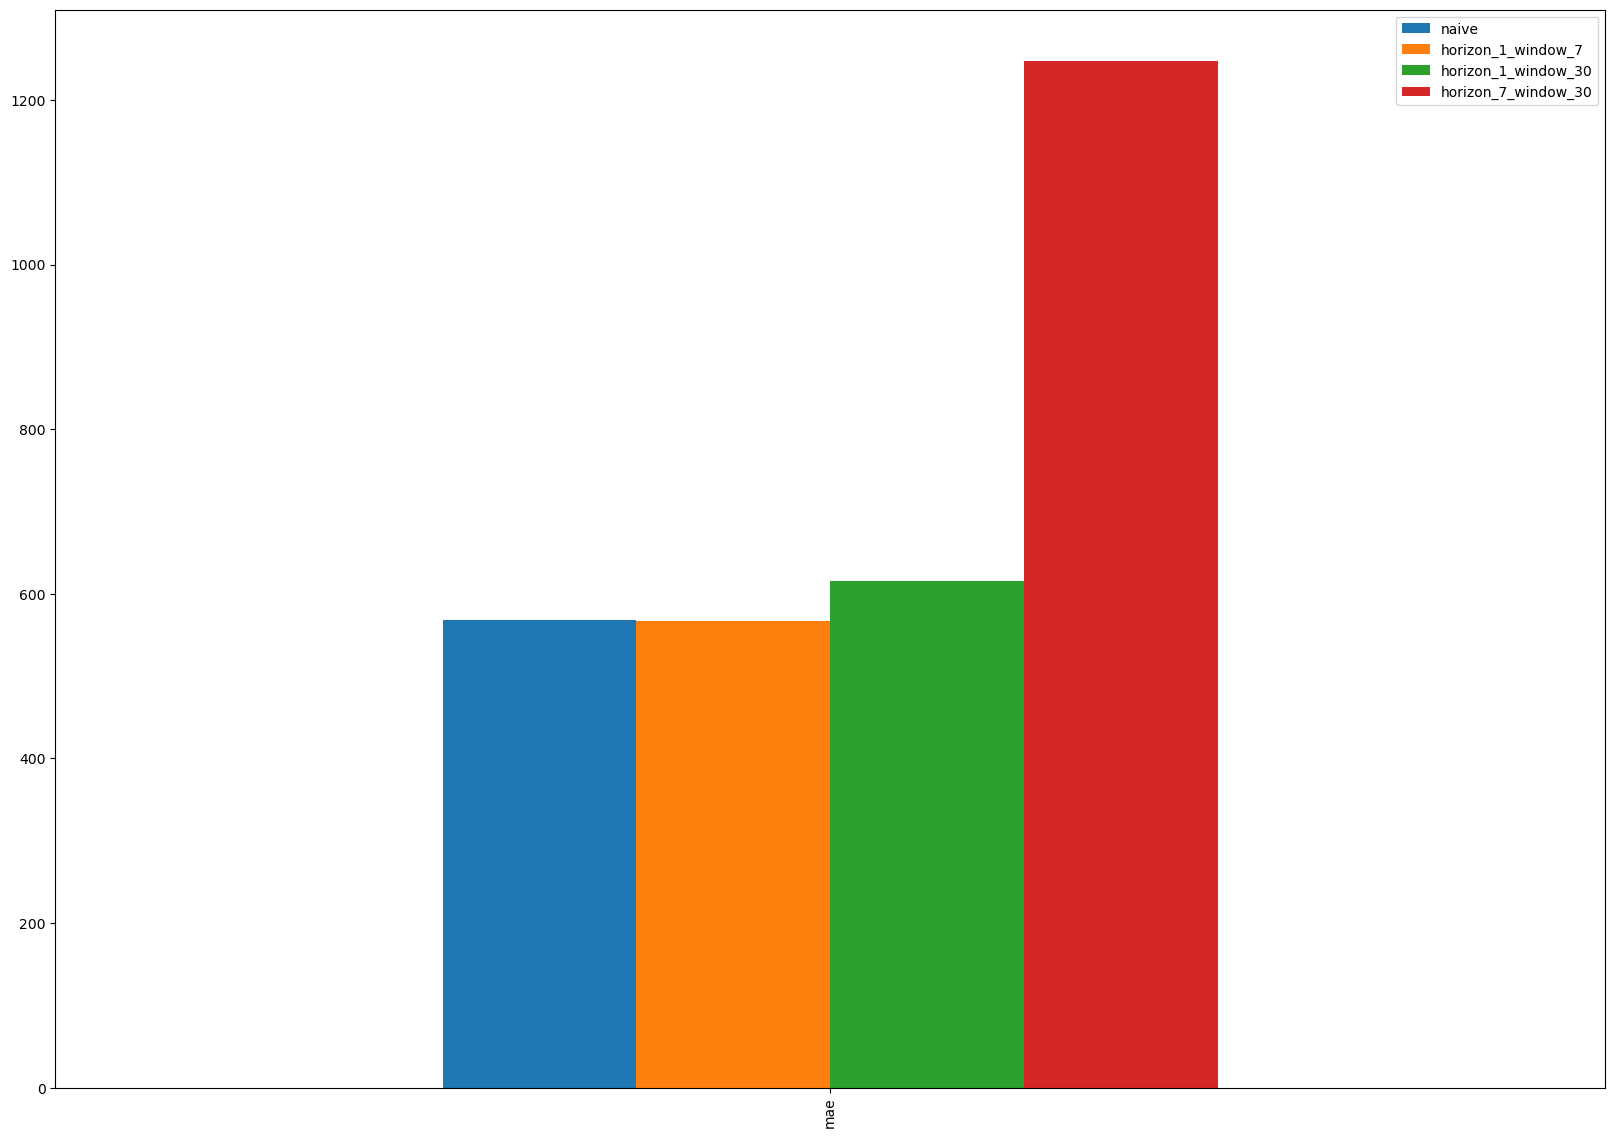

In [78]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]},
             index=["mae"]).plot(figsize=(20, 14), kind="bar")

> 🔑 **Note:** You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naïve model will often get fairly good results.

> 📖 **Resource:** For more on how autocorrelation influences a model's predictions, see the article [How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls by Vegard Flovik](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424).

Video N°324: Preparing data for building a Conv1D model

## Model 4: Conv1D

In [79]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7  # use previous week worth data

In [80]:
# Create windowed data
full_windows, full_labels = make_windows(x=prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [81]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet...

In [82]:
# Check data input shape
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [83]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [84]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for `input_dim`

In [85]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # output = ...?
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


Video N°325: Model 4: Building, fitting and evaluating a Conv1D model on our Bitcoin data

[https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)
`padding="causal"`:
"causal" results in causal(dilated) convolutions, e.g. output[t] does not depend oninput[t+1:]. Useful when modeling temporal data where the model should not violate the temporal order. See WaveNet: A Generative Model for Raw Audio, section2.1. 

In [86]:
tf.random.set_seed(42)

# Create Conv1D model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.Dense(units=HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_4.fit(x=train_windows,
            y=train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1650.2980 INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 2s 39ms/step - loss: 1650.2980 - val_loss: 1148.0192
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 339.4894 - val_loss: 1604.4934
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 212.1595INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 22ms/step - loss: 226.5354 - val_loss: 1082.0520
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 244.8770INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 22ms/step - loss: 193.5596 - val_loss: 1050.6481
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 203.6542INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 25ms/step - loss: 187.9993 - val_loss: 1048.4247
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 142.4780INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 23ms/step - loss: 185.2345 - val_loss: 1038.4575
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 236.3553INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 23ms/step - loss: 183.9484 - val_loss: 1011.4860
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 179.2796 - val_loss: 1015.0641
Epoch 9/100
18/18 [==============================] - 0s 3ms/step - loss: 176.0549 - val_loss: 1013.5480
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 192.6319INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 22ms/step - loss: 173.8213 - val_loss: 971.2894
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 191.5531INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 24ms/step - loss: 171.2901 - val_loss: 950.3145
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 170.0021 - val_loss: 990.6544
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 128.5113INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 22ms/step - loss: 166.5966 - val_loss: 949.3038
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 186.4961INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 23ms/step - loss: 163.5348 - val_loss: 926.1649
Epoch 15/100
18/18 [==============================] - 0s 4ms/step - loss: 161.7803 - val_loss: 936.0984
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 150.8216INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 24ms/step - loss: 157.9845 - val_loss: 879.3455
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 154.3377INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 25ms/step - loss: 155.8692 - val_loss: 869.9829
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 158.2558INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 23ms/step - loss: 152.4404 - val_loss: 866.4313
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 85.2168INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 23ms/step - loss: 149.0668 - val_loss: 853.8788
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 158.5916INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 23ms/step - loss: 147.8939 - val_loss: 816.9844
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 200.5416INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 38ms/step - loss: 146.4775 - val_loss: 798.4120
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 196.9758INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 24ms/step - loss: 144.7260 - val_loss: 798.3975
Epoch 23/100
18/18 [==============================] - 0s 4ms/step - loss: 140.7199 - val_loss: 816.0909
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 160.3157INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 22ms/step - loss: 141.0186 - val_loss: 773.1371
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 145.2408INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 22ms/step - loss: 139.0106 - val_loss: 757.7622
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 142.0162INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 23ms/step - loss: 134.3278 - val_loss: 745.6284
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 188.0709INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 25ms/step - loss: 134.2547 - val_loss: 730.2889
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 130.8282INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 25ms/step - loss: 130.8982 - val_loss: 728.1182
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 123.2336INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 23ms/step - loss: 129.4308 - val_loss: 719.7889
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 132.8474 - val_loss: 817.6055
Epoch 31/100
18/18 [==============================] - 0s 4ms/step - loss: 140.0129 - val_loss: 797.9069
Epoch 32/100
18/18 [==============================] - 0s 3ms/step - loss: 132.0232 - val_loss: 728.7491
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 155.7608INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 24ms/step - loss: 129.4340 - val_loss: 712.6496
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 143.2833INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 25ms/step - loss: 126.0006 - val_loss: 676.8080
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 111.7766INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 22ms/step - loss: 123.3312 - val_loss: 672.5021
Epoch 36/100
18/18 [==============================] - 0s 4ms/step - loss: 126.6393 - val_loss: 737.1110
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 159.5058INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 23ms/step - loss: 125.0150 - val_loss: 659.2724
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 113.6633INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 24ms/step - loss: 122.4764 - val_loss: 656.9151
Epoch 39/100
18/18 [==============================] - 0s 3ms/step - loss: 122.1633 - val_loss: 656.9191
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 116.9597INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 22ms/step - loss: 121.0626 - val_loss: 651.8972
Epoch 41/100
 1/18 [>.............................] - ETA: 0s - loss: 110.3059INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 22ms/step - loss: 121.0838 - val_loss: 642.5714
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 113.3095INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 23ms/step - loss: 123.1276 - val_loss: 640.0481
Epoch 43/100
 1/18 [>.............................] - ETA: 0s - loss: 97.4836INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 37ms/step - loss: 118.5419 - val_loss: 639.8898
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 70.4359INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 23ms/step - loss: 119.4058 - val_loss: 634.5836
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 84.0043INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 26ms/step - loss: 121.2583 - val_loss: 630.8550
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 91.8821INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 25ms/step - loss: 118.2426 - val_loss: 624.8593
Epoch 47/100
18/18 [==============================] - 0s 3ms/step - loss: 124.1239 - val_loss: 698.2415
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 118.2784 - val_loss: 686.1612
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 173.7997INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 22ms/step - loss: 118.9046 - val_loss: 617.4838
Epoch 50/100
 1/18 [>.............................] - ETA: 0s - loss: 136.8826INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 25ms/step - loss: 115.3963 - val_loss: 616.1416
Epoch 51/100
18/18 [==============================] - 0s 4ms/step - loss: 115.7682 - val_loss: 621.4489
Epoch 52/100
18/18 [==============================] - 0s 4ms/step - loss: 115.6466 - val_loss: 621.1716
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 118.2056 - val_loss: 640.8392
Epoch 54/100
18/18 [==============================] - 0s 4ms/step - loss: 120.1038 - val_loss: 692.6852
Epoch 55/100
18/18 [==============================] - 0s 4ms/step - loss: 117.9053 - val_loss: 621.5992
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 115.1348 - val_loss: 816.0287
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 138.3007 - val_loss: 629.7471
Epoch 58/100
18/18 [==============================] - 0s 3ms/step - loss: 122.7587 - val_loss: 636.6699
Epoch 59/100
 1/18 [>.............................] - ETA: 0s - loss: 80.041

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 24ms/step - loss: 113.0208 - val_loss: 608.3807
Epoch 60/100
 1/18 [>.............................] - ETA: 0s - loss: 95.1929INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 24ms/step - loss: 113.1857 - val_loss: 608.3641
Epoch 61/100
18/18 [==============================] - 0s 4ms/step - loss: 113.3543 - val_loss: 614.4901
Epoch 62/100
 1/18 [>.............................] - ETA: 0s - loss: 81.1465INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 23ms/step - loss: 111.3895 - val_loss: 597.2419
Epoch 63/100
18/18 [==============================] - 0s 4ms/step - loss: 113.2063 - val_loss: 608.5518
Epoch 64/100
18/18 [==============================] - 0s 3ms/step - loss: 111.5839 - val_loss: 641.1711
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 136.0903INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 25ms/step - loss: 116.0709 - val_loss: 591.7254
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 119.7276INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 22ms/step - loss: 111.9674 - val_loss: 591.0880
Epoch 67/100
18/18 [==============================] - 0s 4ms/step - loss: 110.9676 - val_loss: 685.4205
Epoch 68/100
18/18 [==============================] - 0s 4ms/step - loss: 115.6738 - val_loss: 708.4863
Epoch 69/100
18/18 [==============================] - 0s 3ms/step - loss: 127.1175 - val_loss: 681.4324
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 123.4585 - val_loss: 613.6745
Epoch 71/100
18/18 [==============================] - 0s 3ms/step - loss: 112.8012 - val_loss: 604.6573
Epoch 72/100
18/18 [==============================] - 0s 3ms/step - loss: 112.6951 - val_loss: 596.3253
Epoch 73/100
 1/18 [>.............................] - ETA: 0s - loss: 123.6400INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 22ms/step - loss: 111.8725 - val_loss: 589.9575
Epoch 74/100
 1/18 [>.............................] - ETA: 0s - loss: 161.9646INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 23ms/step - loss: 111.9566 - val_loss: 588.3151
Epoch 75/100
18/18 [==============================] - 0s 4ms/step - loss: 110.3300 - val_loss: 590.3864
Epoch 76/100
 1/18 [>.............................] - ETA: 0s - loss: 79.5866INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 24ms/step - loss: 110.9104 - val_loss: 581.8433
Epoch 77/100
18/18 [==============================] - 0s 4ms/step - loss: 112.7515 - val_loss: 601.6142
Epoch 78/100
 1/18 [>.............................] - ETA: 0s - loss: 111.2443INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 24ms/step - loss: 109.9156 - val_loss: 581.7128
Epoch 79/100
18/18 [==============================] - 0s 4ms/step - loss: 110.8011 - val_loss: 584.3400
Epoch 80/100
18/18 [==============================] - 0s 4ms/step - loss: 108.8021 - val_loss: 583.8695
Epoch 81/100
18/18 [==============================] - 0s 4ms/step - loss: 111.1206 - val_loss: 594.4631
Epoch 82/100
18/18 [==============================] - 0s 3ms/step - loss: 116.9995 - val_loss: 585.6968
Epoch 83/100
18/18 [==============================] - 0s 4ms/step - loss: 111.8278 - val_loss: 665.3872
Epoch 84/100
18/18 [==============================] - 0s 4ms/step - loss: 112.8385 - val_loss: 587.6593
Epoch 85/100
18/18 [==============================] - 0s 4ms/step - loss: 108.8846 - val_loss: 597.9312
Epoch 86/100
18/18 [==============================] - 0s 3ms/step - loss: 111.2547 - val_loss: 631.1921
Epoch 87/100
18/18 [==============================] - 0s 4ms/step - loss: 11

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 22ms/step - loss: 109.8791 - val_loss: 575.5555
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 108.9615 - val_loss: 648.5355
Epoch 91/100
18/18 [==============================] - 0s 3ms/step - loss: 113.6077 - val_loss: 636.8668
Epoch 92/100
18/18 [==============================] - 0s 3ms/step - loss: 111.0084 - val_loss: 579.4320
Epoch 93/100
18/18 [==============================] - 0s 3ms/step - loss: 115.5004 - val_loss: 632.5238
Epoch 94/100
18/18 [==============================] - 0s 3ms/step - loss: 110.3291 - val_loss: 590.0303
Epoch 95/100
18/18 [==============================] - 0s 3ms/step - loss: 109.5391 - val_loss: 581.8497
Epoch 96/100
18/18 [==============================] - 0s 4ms/step - loss: 115.2063 - val_loss: 611.2410
Epoch 97/100
18/18 [==============================] - 0s 4ms/step - loss: 110.8734 - val_loss: 600.7747
Epoch 98/100
 1/18 [>.............................] - ETA: 0s - loss: 120.52

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 39ms/step - loss: 109.7974 - val_loss: 572.7509
Epoch 99/100
 1/18 [>.............................] - ETA: 0s - loss: 151.9598INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 7, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2ada20>, 139772397592032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c2afac0>, 139772396864496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c215d80>, 139772398647568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1f4c217ac0>, 139772398645328), {}).


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 0s 23ms/step - loss: 109.1784 - val_loss: 571.7246
Epoch 100/100
18/18 [==============================] - 0s 4ms/step - loss: 110.2858 - val_loss: 656.7474


In [87]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [88]:
# Evaluate model...
model_4.evaluate(x=test_windows, y=test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 656.7474


656.7474365234375

In [89]:
# Load back in best performing Conv1D and re-evaluate
model_4 = tf.keras.models.load_model(filepath="model_experiments/model_4_conv1D")
model_4.evaluate(x=test_windows, y=test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 571.7246


571.724609375

In [90]:
# Make predictions
model_4_preds = make_preds(model=model_4, input_data=test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8879.557, 8777.953, 8980.213, 8774.28 , 8728.307, 8713.957,
       8670.26 , 8530.902, 8440.081, 8505.682], dtype=float32)>

In [91]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 571.7246,
 'mse': 1187114.8,
 'rmse': 1089.548,
 'mape': 2.5644646,
 'mase': 1.0043617}

Video N°326: Model 5: Building, fitting and evaluating a LSTM (RNN) model on our Bitcoin data

## Model 5: RNN (LSTM)

Let's build an RNN model for our time series data.

We'll use the same data we created previously.

In [92]:
train_windows[:5]

array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ],
       [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
        123.033  ],
       [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
        124.049  ],
       [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
        125.96116],
       [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
        125.27966]])

In [93]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(units=128, return_sequences=True)(x)
x = layers.LSTM(units=128, activation="relu")(x)
# x = layers.Dense(units=32, activation="relu")(x)
outputs = layers.Dense(units=HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_5_LSTM")

# Compile
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])


Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1763.1484 INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 66ms/step - loss: 1763.1484 - val_loss: 3972.1094
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 286.7698INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 60ms/step - loss: 283.4690 - val_loss: 1054.8384
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 199.7796INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 58ms/step - loss: 198.4653 - val_loss: 1048.9717
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 187.1955 - val_loss: 1158.9397
Epoch 5/100
17/18 [===========================>..] - ETA: 0s - loss: 202.1737INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 72ms/step - loss: 199.9643 - val_loss: 1048.6971
Epoch 6/100
16/18 [=========================>....] - ETA: 0s - loss: 193.8185INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 58ms/step - loss: 193.9135 - val_loss: 1046.6624
Epoch 7/100
15/18 [========================>.....] - ETA: 0s - loss: 195.1456INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 60ms/step - loss: 189.3453 - val_loss: 1018.8404
Epoch 8/100
14/18 [======================>.......] - ETA: 0s - loss: 179.8375INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 60ms/step - loss: 181.1556 - val_loss: 1011.8129
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 178.7218 - val_loss: 1014.6526
Epoch 10/100
13/18 [====================>.........] - ETA: 0s - loss: 170.5519INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 61ms/step - loss: 176.3529 - val_loss: 999.9646
Epoch 11/100
17/18 [===========================>..] - ETA: 0s - loss: 174.7554INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 74ms/step - loss: 174.4358 - val_loss: 969.3218
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 172.5577 - val_loss: 990.9786
Epoch 13/100
18/18 [==============================] - 0s 4ms/step - loss: 169.4590 - val_loss: 985.6793
Epoch 14/100
15/18 [========================>.....] - ETA: 0s - loss: 164.6364INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 61ms/step - loss: 166.3782 - val_loss: 957.3928
Epoch 15/100
13/18 [====================>.........] - ETA: 0s - loss: 164.2125INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 61ms/step - loss: 165.8552 - val_loss: 925.9130
Epoch 16/100
14/18 [======================>.......] - ETA: 0s - loss: 161.3334INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 61ms/step - loss: 161.3339 - val_loss: 912.7850
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 158.9668 - val_loss: 954.4021
Epoch 18/100
16/18 [=========================>....] - ETA: 0s - loss: 163.1258INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 62ms/step - loss: 157.9604 - val_loss: 894.8334
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 154.6097 - val_loss: 907.3859
Epoch 20/100
18/18 [==============================] - ETA: 0s - loss: 151.9946INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 61ms/step - loss: 151.9946 - val_loss: 852.0743
Epoch 21/100
18/18 [==============================] - 0s 6ms/step - loss: 150.3028 - val_loss: 852.2761
Epoch 22/100
18/18 [==============================] - ETA: 0s - loss: 146.9536INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 83ms/step - loss: 146.9536 - val_loss: 834.3241
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 144.9883 - val_loss: 837.9971
Epoch 24/100
16/18 [=========================>....] - ETA: 0s - loss: 144.3172INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 74ms/step - loss: 143.9239 - val_loss: 819.1142
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 148.7145INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 64ms/step - loss: 140.5361 - val_loss: 793.2488
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 143.5104INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 67ms/step - loss: 139.3774 - val_loss: 766.4003
Epoch 27/100
18/18 [==============================] - 0s 4ms/step - loss: 137.9391 - val_loss: 774.5911
Epoch 28/100
16/18 [=========================>....] - ETA: 0s - loss: 134.5891INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 69ms/step - loss: 135.4809 - val_loss: 744.5633
Epoch 29/100
15/18 [========================>.....] - ETA: 0s - loss: 136.2352INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 89ms/step - loss: 135.0625 - val_loss: 731.1667
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 134.2104 - val_loss: 912.3644
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 165.5674INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 65ms/step - loss: 140.3117 - val_loss: 713.4701
Epoch 32/100
16/18 [=========================>....] - ETA: 0s - loss: 128.6640INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 69ms/step - loss: 130.5820 - val_loss: 706.1415
Epoch 33/100
18/18 [==============================] - ETA: 0s - loss: 129.4502INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 74ms/step - loss: 129.4502 - val_loss: 699.8118
Epoch 34/100
14/18 [======================>.......] - ETA: 0s - loss: 129.8561INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 69ms/step - loss: 126.5721 - val_loss: 694.5980
Epoch 35/100
15/18 [========================>.....] - ETA: 0s - loss: 127.5015INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 64ms/step - loss: 124.8925 - val_loss: 688.0362
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 130.6504 - val_loss: 694.6633
Epoch 37/100
16/18 [=========================>....] - ETA: 0s - loss: 123.7573INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 92ms/step - loss: 124.3984 - val_loss: 668.5470
Epoch 38/100
16/18 [=========================>....] - ETA: 0s - loss: 123.0827INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 69ms/step - loss: 122.9827 - val_loss: 664.3148
Epoch 39/100
18/18 [==============================] - 0s 4ms/step - loss: 121.9661 - val_loss: 686.6830
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 123.3012INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 61ms/step - loss: 121.0368 - val_loss: 651.6111
Epoch 41/100
 1/18 [>.............................] - ETA: 0s - loss: 110.5365INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 62ms/step - loss: 121.5489 - val_loss: 647.4946
Epoch 42/100
16/18 [=========================>....] - ETA: 0s - loss: 119.9346INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 60ms/step - loss: 120.4867 - val_loss: 640.2909
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 119.4500 - val_loss: 641.5363
Epoch 44/100
14/18 [======================>.......] - ETA: 0s - loss: 117.4734INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 76ms/step - loss: 119.7352 - val_loss: 634.1593
Epoch 45/100
15/18 [========================>.....] - ETA: 0s - loss: 114.9945INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 62ms/step - loss: 117.3519 - val_loss: 627.3818
Epoch 46/100
18/18 [==============================] - 0s 6ms/step - loss: 116.5658 - val_loss: 638.0065
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 121.4865 - val_loss: 637.7452
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 117.4373 - val_loss: 680.7294
Epoch 49/100
18/18 [==============================] - 0s 4ms/step - loss: 117.5971 - val_loss: 652.6608
Epoch 50/100
18/18 [==============================] - 0s 4ms/step - loss: 126.7051 - val_loss: 677.5515
Epoch 51/100
18/18 [==============================] - 0s 4ms/step - loss: 115.9493 - val_loss: 628.8296
Epoch 52/100
 1/18 [>.............................] - ETA: 0s - loss: 121.8986INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 58ms/step - loss: 116.5046 - val_loss: 608.5930
Epoch 53/100
14/18 [======================>.......] - ETA: 0s - loss: 116.4146INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 60ms/step - loss: 115.1973 - val_loss: 606.1313
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 113.2649 - val_loss: 629.5983
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 133.6798INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 59ms/step - loss: 114.8618 - val_loss: 604.3150
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 116.1753 - val_loss: 705.4448
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 129.9162 - val_loss: 612.7598
Epoch 58/100
16/18 [=========================>....] - ETA: 0s - loss: 116.3416INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 77ms/step - loss: 115.3397 - val_loss: 598.2750
Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 112.2333 - val_loss: 604.1483
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 113.4563 - val_loss: 603.7922
Epoch 61/100
18/18 [==============================] - 0s 5ms/step - loss: 112.4441 - val_loss: 636.6869
Epoch 62/100
17/18 [===========================>..] - ETA: 0s - loss: 113.8575INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 64ms/step - loss: 113.5321 - val_loss: 593.6165
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 113.2510 - val_loss: 594.6627
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 113.1538 - val_loss: 656.0119
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 117.1870 - val_loss: 622.2375
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 111.9748 - val_loss: 606.5236
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 113.6746 - val_loss: 618.4194
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 117.4532 - val_loss: 594.0599
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 117.3694 - val_loss: 647.1616
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 118.5824 - val_loss: 618.8731
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 11

INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 63ms/step - loss: 112.7433 - val_loss: 584.2007
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 110.2051 - val_loss: 589.2797
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 111.0275 - val_loss: 585.0895
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 111.1721 - val_loss: 625.2615
Epoch 76/100
17/18 [===========================>..] - ETA: 0s - loss: 111.6973INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 59ms/step - loss: 111.8185 - val_loss: 582.0508
Epoch 77/100
18/18 [==============================] - 0s 6ms/step - loss: 112.3862 - val_loss: 602.4235
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 111.4335 - val_loss: 593.2084
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 110.8418 - val_loss: 590.9322
Epoch 80/100
18/18 [==============================] - 0s 6ms/step - loss: 112.4684 - val_loss: 596.8097
Epoch 81/100
18/18 [==============================] - 0s 6ms/step - loss: 112.0789 - val_loss: 583.3932
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 112.8865 - val_loss: 594.5199
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 111.7882 - val_loss: 636.9045
Epoch 84/100
18/18 [==============================] - ETA: 0s - loss: 113.5726INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 62ms/step - loss: 113.5726 - val_loss: 581.2637
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 110.0885 - val_loss: 621.6672
Epoch 86/100
18/18 [==============================] - 0s 4ms/step - loss: 112.6276 - val_loss: 673.8267
Epoch 87/100
15/18 [========================>.....] - ETA: 0s - loss: 114.4166INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 63ms/step - loss: 114.2084 - val_loss: 575.4753
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 109.1923 - val_loss: 578.3751
Epoch 89/100
18/18 [==============================] - 0s 4ms/step - loss: 112.2414 - val_loss: 587.0685
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 111.5181 - val_loss: 713.7257
Epoch 91/100
17/18 [===========================>..] - ETA: 0s - loss: 111.8404INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 81ms/step - loss: 112.4091 - val_loss: 575.4441
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 110.8249 - val_loss: 594.4686
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 111.3154 - val_loss: 596.7787
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 110.0507 - val_loss: 585.0914
Epoch 95/100
18/18 [==============================] - 0s 4ms/step - loss: 109.7000 - val_loss: 584.5224
Epoch 96/100
 1/18 [>.............................] - ETA: 0s - loss: 119.1360INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 1s 60ms/step - loss: 108.5609 - val_loss: 572.4097
Epoch 97/100
18/18 [==============================] - 0s 6ms/step - loss: 109.1678 - val_loss: 623.6639
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 109.4591 - val_loss: 584.4049
Epoch 99/100
18/18 [==============================] - 0s 6ms/step - loss: 109.3494 - val_loss: 577.2717
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 116.8308 - val_loss: 585.1036


In [94]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(x=test_windows, y=test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 572.4097


572.4097290039062

In [95]:
# Make prediction with our LSTM model
model_5_preds = make_preds(model=model_5, input_data=test_windows)
model_5_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([8916.285 , 8821.97  , 8998.526 , 8807.1045, 8789.477 ],
      dtype=float32)>

In [96]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 572.4097,
 'mse': 1190701.9,
 'rmse': 1091.1929,
 'mape': 2.5745006,
 'mase': 1.0055654}

> 🔑 **Note:** Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.

Video N°327: Investigating how to turn our univariate time series into multivariate

## Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use?

How about the bitcoin halving events?

[https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving)

In [97]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [98]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

Video N°328: Creating and plotting a multivariate time series with BTC price and block reward

In [99]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [100]:
# Add in a block_reward column


In [101]:
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [102]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


<Axes: xlabel='Date'>

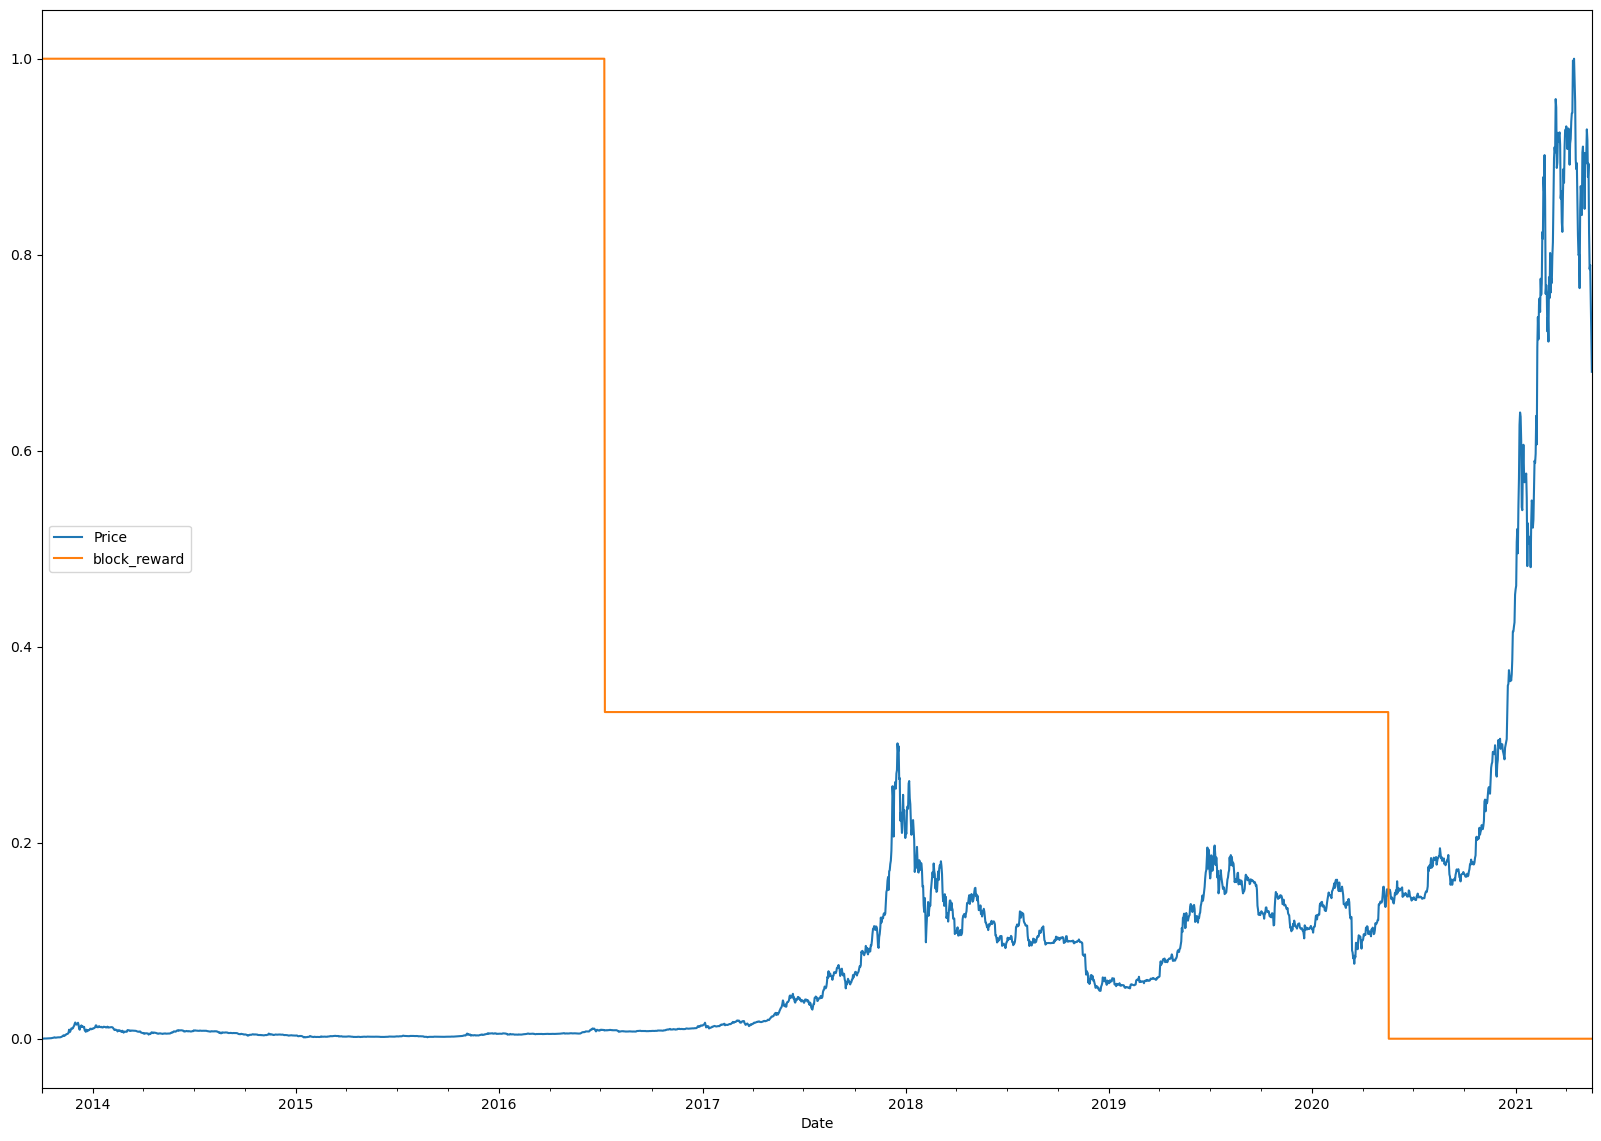

In [103]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(data=minmax_scale(X=bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(20, 14))

Video N°329: Preparing our multivariate time series for a model

## Making a windowed dataset with pandas

Previously, we've turned our univariate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.

[https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html)

In [104]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [105]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
    bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [106]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [107]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [108]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [109]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

Video N°330: Model 6: Building, fitting and evaluating a multivariate time series model

## Model 6: Dense (multivariate time series)

In [110]:
tf.random.set_seed(42)

# Make multivariate time series model
